# Azure OpenAI Assistant API Mutli-Agent Example

## Setups

REQUIREMENTS:

Assistant models - Latest 1106 models

GPT4 Vision Model - vision-preview

Dall-e 3 Model - dall-e-3 3.0

#Install the required packages using pip. 

In [ ]:
%pip install -r requirements.txt

## Imports and environment variables

It's best practice to keep your secrets and keys in an environment variable file. You can do this by editing the "sample.env" file and renaming it to ".env".

In [21]:
import io
import os
import time
from datetime import datetime
from typing import Iterable
from matplotlib import pyplot as plt  
import cv2
import base64
from typing import List 
import requests  
from io import BytesIO  
from PIL import Image  
from pathlib import Path  

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile

load_dotenv()

api_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_KEY")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# name of the AOAI model deployment that is compatible with the Assistants API you want to use
api_deployment_name = os.getenv("GPT4_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
api_deployment_name_vision = os.getenv("GPT4_VISION_DEPLOYMENT_NAME")

# name of the model deployment for DALL·E 3
api_deployment_name_dalle = os.getenv("DALLE3_DEPLOYMENT_NAME")

client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

## Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


#Image generator agent definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [22]:
name_dl = "dalle_assistant"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [23]:

dalle_assistant = client.beta.assistants.create(
  name=name_dl,
  instructions=instructions_dl,
  model=api_deployment_name,
  tools=tools
)

## Image Generator "generate_image" function

This function calls the Dalle-3 image generator given the prompt

In [24]:
def generate_image(prompt: str) -> str:  
    """  
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.  
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.  
    """  
    response = client.images.generate(  
        model=api_deployment_name_dalle,  
        prompt=prompt,  
        size="1024x1024",  
        quality="standard",  
        n=1  
    )  
  
    # Retrieve the image URL from the response (assuming response structure)  
    image_url = response.data[0].url  
  
    # Open the image from the URL and save it to a temporary file.  
    im = Image.open(requests.get(image_url, stream=True).raw)  
  
    # Define the filename and path where the image should be saved.  
    filename = "temp.jpg"  
    local_path = Path(filename)  
  
    # Save the image.  
    im.save(local_path)  
  
    # Get the absolute path of the saved image.  
    full_path = str(local_path.absolute())  
    
    img = cv2.imread('temp.jpg', cv2.IMREAD_UNCHANGED)  
    
    # Convert the image from BGR to RGB for displaying with matplotlib,  
    # because OpenCV uses BGR by default and matplotlib expects RGB.  
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    # Display the image with matplotlib.  
    plt.imshow(img_rgb)  
    plt.axis('off')  # Turn off axis labels.  
    plt.show()  

    # Return the full path of the saved image.  
    print("Dalle Assistant Message: " + full_path)
    return full_path  


# Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


#Vision assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [25]:
name_vs = "vision_assistant"
instructions_vs = """As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision before you provide feedback to the user."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "image_filename": {
                        "type": "string",
                        "description": "The local image file name including the full path",
                    }
                },
                "required": ["image_filename"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [26]:
vision_assistant = client.beta.assistants.create(
    name=name_vs,
    instructions=instructions_vs,
    model=api_deployment_name,
    tools=tools
)

## Vision Assistant "analyze_image" function

This function calls the GPT4 Vision image analyzes given an image

In [27]:
def analyze_image(image_filename: str) -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    import base64
    base64_image = base64.b64encode(open("temp.jpg", "rb").read()).decode("utf-8")
    content_images = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}} for base64_image in [base64_image]]
    print(content_images)
    response = client.chat.completions.create(
    model= api_deployment_name_vision,
    messages=[
        {
        "role": "user",
                "content": [
                {"type": "text", "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis."}
            ] + content_images,
        }
    ],
    max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

## User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


### Proxy Assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent including agents this user proxy has access to.
- Function = functions the agents has access to. send_message sends messages to the other agents and agent_name specifies which agent to communicate with

In [28]:

name_pa = "user_proxy"
agent_arr = ["dalle_assistant","vision_assistant"]
agent_string = ""
for item in agent_arr: 
    agent_string += f"{item}\n"
    
instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.
You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.
When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.
"""

#Usually a user will provide a prompt to generate an image and you call the "dalle_assistant". After the return of the file path of the "dalle_assistant" you call the "vision_assistant" for criticing the image. 
#Then you calle the "dalle_assistant" again followed by the "vision_assistant" and so on until the user is satisfied with the result.
tools = [
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    }
                },
                "required": ["query","agent_name"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [29]:
user_proxy = client.beta.assistants.create(
  name=name_pa,
  instructions=instructions_pa,
  model=api_deployment_name,
  tools=tools
)

### Proxy Assistant "send_message" function

This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_threads 

In [30]:
from typing import Dict, Optional  

agents_threads: Dict[str, Dict[str, Optional[str]]] = {  
    "dalle_assistant": {  
        "agent": dalle_assistant, 
        "thread": None
    },
    "vision_assistant": {  
        "agent": vision_assistant, 
        "thread": None
    } 
}  

# Define the send_message function with only the query parameter  
def send_message(query: str, agent_name: str) -> str:  
    # Check if the agent_name is in agents_threads  
    if agent_name not in agent_arr:  
        print(f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***")  
        #return None  
    # If the program has not exited, proceed with setting the agent recipient  
    recipient_type = agent_name  
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient  
    recipient_type = agent_name  
    recipient_info = agents_threads[recipient_type] 
    
    #Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:  
        thread_object = client.beta.threads.create()  
        recipient_info["thread"] = thread_object  

    # This function dispatches a message to the proper agent and it's thread
    message = dispatch_message(query, recipient_info["agent"], recipient_info["thread"])  
    print("Proxy Assistant Message: " + message)
    return message  


## The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [31]:
import time
import json

def dispatch_message(message, agent, thread):
  

    #Loops through all the agents functions to determine which function to use
    
    available_functions = {}  
      
    # Iterate through each tool in the agent.tools list  
    for tool in agent.tools:  
        # Check if the tool has a 'function' attribute  
        if hasattr(tool, 'function'):  
            function_name = tool.function.name  
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary  
            if function_name in globals():  
                available_functions[function_name] = globals()[function_name]  
        else:  
            # Handle the case where the tool does not have a 'function' attribute  
            print("This tool does not have a 'function' attribute.")  
  
    # Draft a new message as part of the ongoing conversation.
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )
    # Carry out the tasks delineated in this discussion thread.
    run = client.beta.threads.runs.create(
      thread_id=thread.id,
      assistant_id=agent.id,
    )
    
    while True:
      # Await the completion of the thread execution.
      while run.status in ['queued', 'in_progress']:
        run = client.beta.threads.runs.retrieve(
          thread_id=thread.id,
          run_id=run.id
        )
        time.sleep(1)

      # If an action is necessary, initiate the appropriate function to perform the task.
      if run.status == "requires_action":
        tool_calls = run.required_action.submit_tool_outputs.tool_calls
        tool_outputs = []
        for tool_call in tool_calls:
          tool_responses = []
          if (
              run.required_action.type == "submit_tool_outputs"
              and run.required_action.submit_tool_outputs.tool_calls is not None
          ):
              tool_calls = run.required_action.submit_tool_outputs.tool_calls

              for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")
                            
                            #Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                            
                            
        # Present the outcomes produced by the tool.
        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_responses
        )
        
      # if the run is completed, return the assistant message else provide error
      elif run.status == "failed":
        raise Exception("Run Failed. ", run.last_error)
      # Craft a reply from the assistant.
      else:
        messages = client.beta.threads.messages.list(
          thread_id=thread.id
        )
        
        #Transmit the response message back to the facilitating agent.
        message = messages.data[0].content[0].text.value
        return message

# Example Questions:


1.   Generate an image of a boat drifting in the water and analyze it and enhance the image
2.   Generate an image of a space civilization, analyze it and enhance it. Do this several times until image satisfies request

Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 


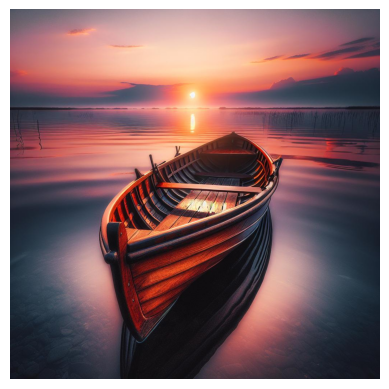

Dalle Assistant Message: c:\Users\christinpohl\Downloads\AzureOpenAIMultiAgentAssistantAPI\venv\temp.jpg
Proxy Assistant Message: Here is the image of a boat drifting in the water:

![Boat Drifting in Water](sandbox:/c:\Users\christinpohl\Downloads\AzureOpenAIMultiAgentAssistantAPI\venv\temp.jpg)
[{'type': 'image_url', 'image_url': {'url': ''}}]
Vision Assistant Message: This image is a beautifully composed photograph of a single wooden boat on calm waters during sunset. The colors are vibrant, with warm tones that enhance the feeling of serenity and tranquility. The reflection of the boat on the water is clear, adding a sense of depth to the image. The sun is positioned perfectly on the horizon, creating a natural leading line that draws the viewer's eye towards the boat. 

One criticism of this image could be that it feels a bit too perfect and may lack a sense of authenticity or spontaneity that can make a photograph feel more alive. Additionally, while the colors are beautiful, the
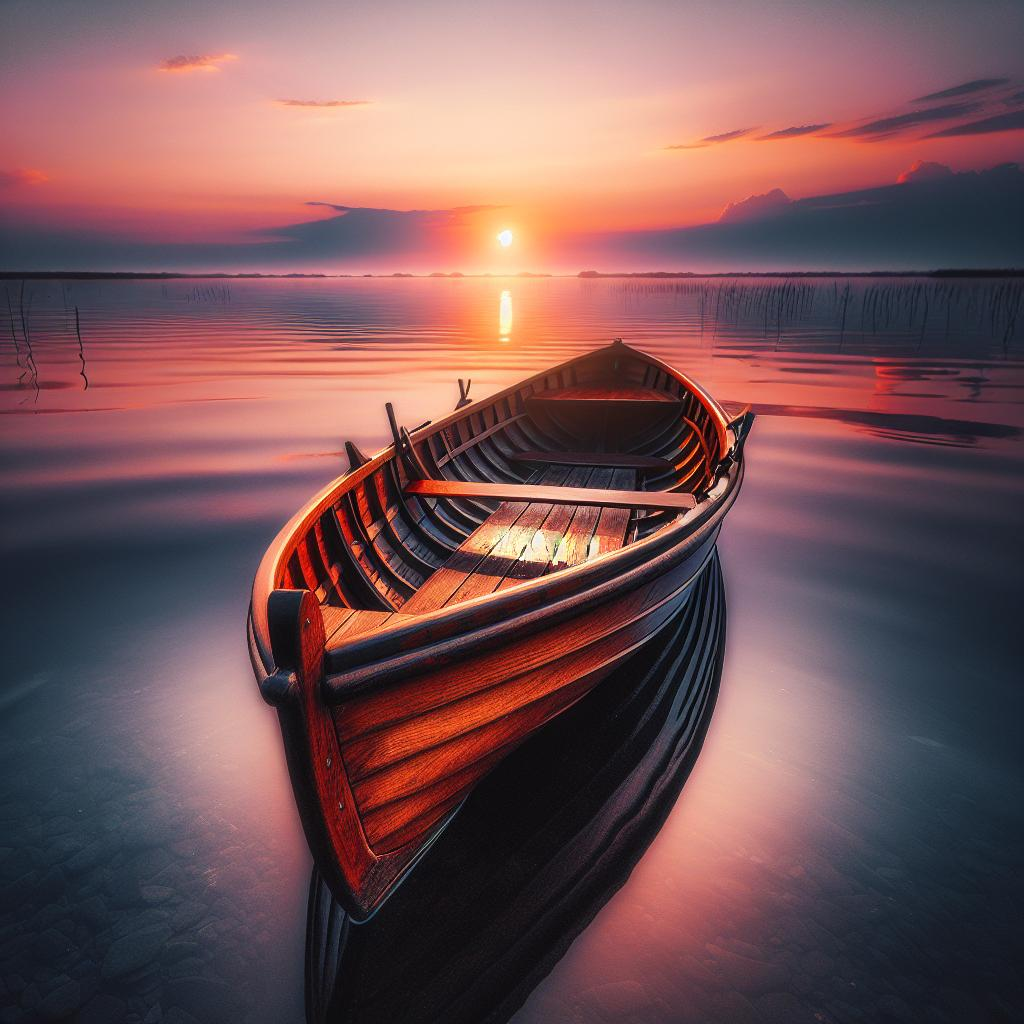

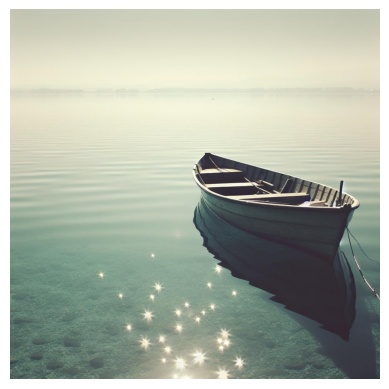

Dalle Assistant Message: c:\Users\christinpohl\Downloads\AzureOpenAIMultiAgentAssistantAPI\venv\temp.jpg
Proxy Assistant Message: I have generated the image, but it appears that there was a mistake with displaying it. Let's try again.

Here is the image of a boat drifting in the water as you requested:

![Boat Drifting in Water](sandbox:/c:\Users\christinpohl\Downloads\AzureOpenAIMultiAgentAssistantAPI\venv\temp.jpg)
[{'type': 'image_url', 'image_url': {'url': ''}}]
Vision Assistant Message: Analysis and Criticism:

This image depicts a serene and tranquil scene of a lone boat floating on a calm, clear body of water. The reflection of the boat is clearly visible on the water's surface, creating a symmetrical visual effect. Light is emanating from the water, creating a sparkly and magical atmosphere. The color palette is muted and consists mostly of cool tones, which contributes to the overall peaceful mood of the image.

One criticism of the image is that the composition lacks a focal 
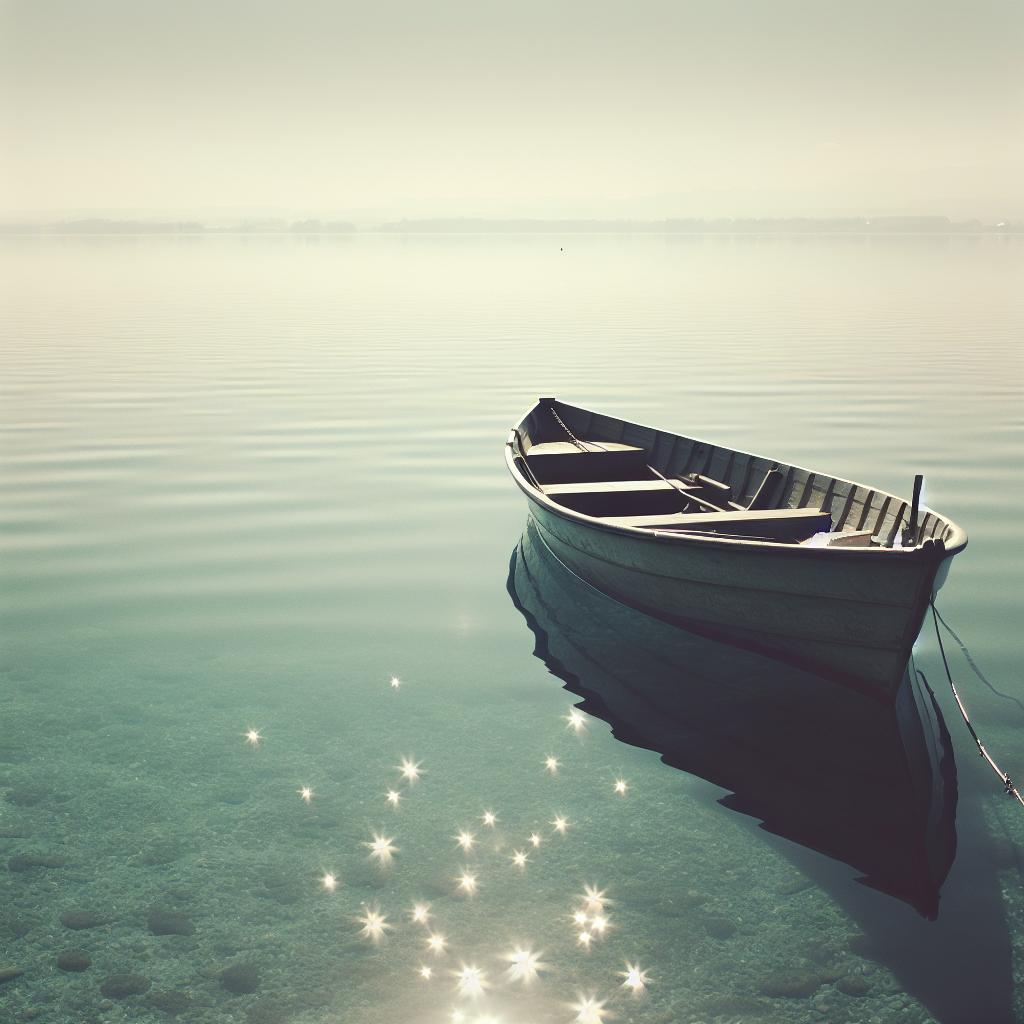

In [32]:
thread = client.beta.threads.create()

#Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)

In [33]:
# why do we sometimes enter the analyze image function and sometimes not?
# why are never more than two images created?

In [34]:
print(message)

The image of a boat drifting in water has been generated and analyzed. While the image cannot be displayed directly here, the analysis has identified areas for improvement and provided specific suggestions to enhance its visual appeal. Here are the proposed enhancements:

1. Introduce a focal point by adding color to make the boat stand out more.
2. Increase contrast to help distinguish the boat from the water and add depth.
3. Incorporate a background with natural elements like trees or mountains to provide context and a sense of scale.
4. Capture the image during the golden hour for warm sunlight effects creating a soft glow on the water and landscape.

These enhancements will be applied to optimize the aesthetics of the image. Unfortunately, due to the limitations of this platform, the enhanced image cannot be displayed here. However, with these suggestions, one can imagine the improvements that would result in a more striking and visually appealing image.


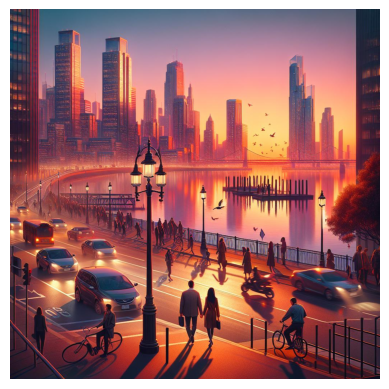

Dalle Assistant Message: c:\Users\christinpohl\Downloads\AzureOpenAIMultiAgentAssistantAPI\venv\temp.jpg


'c:\\Users\\christinpohl\\Downloads\\AzureOpenAIMultiAgentAssistantAPI\\venv\\temp.jpg'

In [35]:
generate_image("message")